## GeoHacking coastal edges classification.
* Classification with Neural Net included!

In [63]:
import pandas as pd
import pandas_ml as pd_ml
import numpy as np
from numpy import linalg as LA
import scipy

%matplotlib notebook

import matplotlib.pylab as py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from matplotlib.colors import ListedColormap
from sklearn import neighbors
from sklearn.metrics import confusion_matrix
import itertools
#import plotly.plotly as ply
#from plotly.graph_objs import *
import tensorflow as tf
#from hub_toolbox.IntrinsicDim import intrinsic_dimension
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
###
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

In [64]:
filename='TrainingTestingPtsUtm.csv'
d=pd.read_csv(filename, sep=',')   ## uncomment for new files
print(d.head())    
print(d.shape)              
colNames=['Xcoord', 'Ycoord','RED','GREEN','BLUE','NIR','class']
d.columns=colNames     ## uncomment for new files
d.to_hdf('CoastalEdges.h5','table')

        XCoord       YCoord  RED  GREEN  BLUE  NIR  LCCODE
0  393760.4806  4806041.171  115    127   139    3       1
1  393851.7445  4805986.912  190    192   184  195       1
2  393694.1029  4805909.724  245    247   245  245       1
3  393665.2445  4805953.477   51     87    95   50       1
4  393774.8389  4805959.545   73     99   100    6       1
(1432, 7)


7 features and 4 clases (1:  , 2:  , 3:   , 4: ); 1432 examples.

In [65]:
df=pd.read_hdf('CoastalEdges.h5','table')
df.describe()

,Xcoord,Ycoord,RED,GREEN,BLUE,NIR,class
count,1432.000000,1.432000e+03,1432.000000,1432.000000,1432.000000,1432.000000,1432.00000
mean,388392.436369,4.797230e+06,126.388966,135.713687,144.097765,52.481145,2.47067
std,2212.771973,4.248044e+03,65.974268,51.573051,34.615350,44.866208,1.16157
min,385716.910400,4.785724e+06,29.000000,56.000000,81.000000,1.000000,1.00000
25%,386751.120325,4.794958e+06,65.000000,92.000000,119.000000,11.000000,1.00000
50%,387507.651850,4.797244e+06,104.500000,120.000000,134.000000,44.000000,2.00000
75%,389308.772675,4.799767e+06,183.000000,177.000000,168.000000,82.000000,4.00000
max,393982.161900,4.806041e+06,255.000000,255.000000,255.000000,245.000000,4.00000


<IPython.core.display.Javascript object>


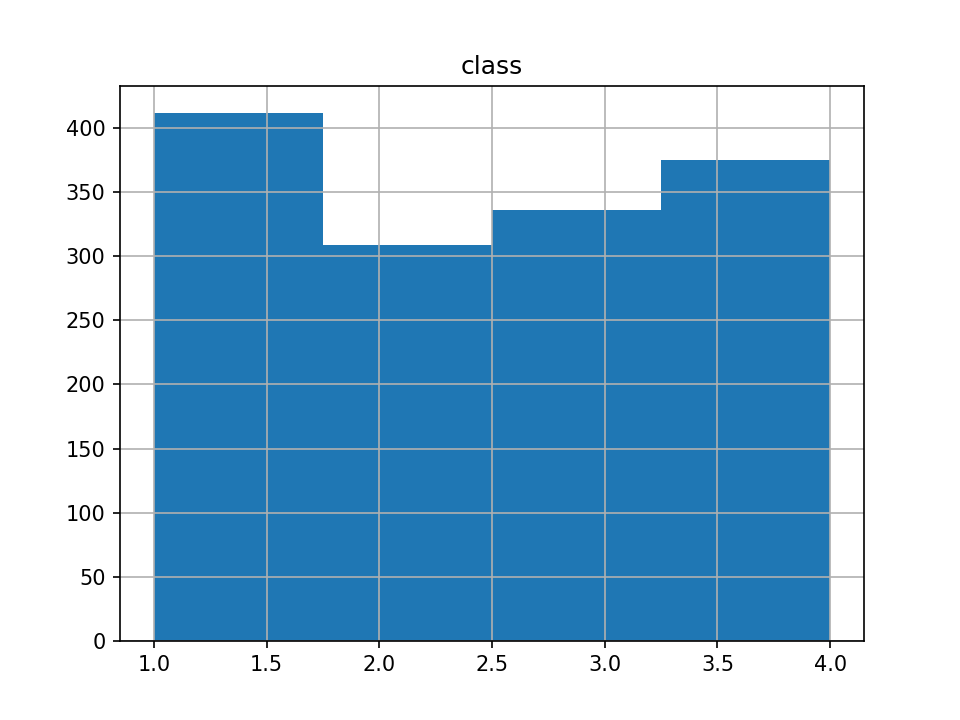

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F39A933DA0>]],
      dtype=object)

In [66]:
df.hist(column='class',bins=4)

In [67]:
df['class'].value_counts()

1    412
4    375
3    336
2    309
Name: class, dtype: int64

In [68]:
df['class'].value_counts()
ndpoints=df.shape[0]

In [69]:
nsubset=1
k=10  ## k nearest neighbors
#index=np.random.choice(ndpoints,nsubset)
grid=np.floor(ndpoints/nsubset).astype(int)
#grid=100
color=df['class'].iloc[0:ndpoints:grid]
#edf=df.iloc[1:nsubset]
cdf=df[['Xcoord','Ycoord']]
ecdf=cdf.iloc[0:ndpoints]
sd=scipy.spatial.cKDTree(ecdf)
nn=sd.query(ecdf.iloc[0:ndpoints:grid], k)
nn_all=sd.query(ecdf.iloc[0:ndpoints], k)
###
adf=df[['Xcoord','Ycoord','RED','GREEN','BLUE','NIR']]
print(adf.shape)

(1432, 6)


In [70]:
#yc=df['class'].iloc[0:ndpoints:grid]    ### With neighbor matrix step.
yc=df['class'].iloc[0:ndpoints]      ### ommiting neighbor matrix step  ###

X=adf ## no feature engennering for now

X_train, X_test, y_train, y_test = train_test_split(X, yc, test_size=0.20, random_state=42)

### Stadarization + Normalization +####
## Standarization
scaler = StandardScaler()
scaler.fit(X_train)
Xpca_train_scaled=scaler.transform(X_train)
Xpca_test_scaled=scaler.transform(X_test) 
Xpca_train=preprocessing.normalize(Xpca_train_scaled, norm='l2')
Xpca_test=preprocessing.normalize(Xpca_test_scaled, norm='l2')
X_train=Xpca_train
X_test=Xpca_test

##### K Nearest Neighbor classifier

![alt text](KNN.png "KNN")

The KNN approach, using $K=3$, is illustrated in a simple situation with six blue observations and six orange observations (``An Introduction to Statistical Learning with Applications in R'' by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani, Springer, 8th Edition, 2017.)


##### We apply the "trained" clasifier to the test data, Xtest.

In [71]:
n_neighbors = 10
classifier = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
y_pred = classifier.fit(X_train, y_train).predict(X_test)
class_names=np.unique(yc)
target_names=class_names.tolist



$f_1$ scores :

\begin{equation}
PRE_{micro}=\dfrac{TP_1 + TP_2 + \dots + TP_N}{TP_1 + TP_2 + \dots + TP_N+ FP_1 + FP_2 + \dots + FP_N},
\end{equation}

where $TP_i$ means true positive on the $ith$ class and $FP_i$ means false negative on the $ith$ class.

We provide the $F_1$ score=$ 2 \dfrac{PRE_{micro} \cdot Recall}{PRE_{micro} + Recall}, $
where the recall (or sensitivity) is given by 
\begin{equation}
\dfrac{\sum_{j=1}^N TP_j}{\sum_{j=1}^N TP_j + \sum_{j=1}^N FN_j}.
\end{equation}




<IPython.core.display.Javascript object>


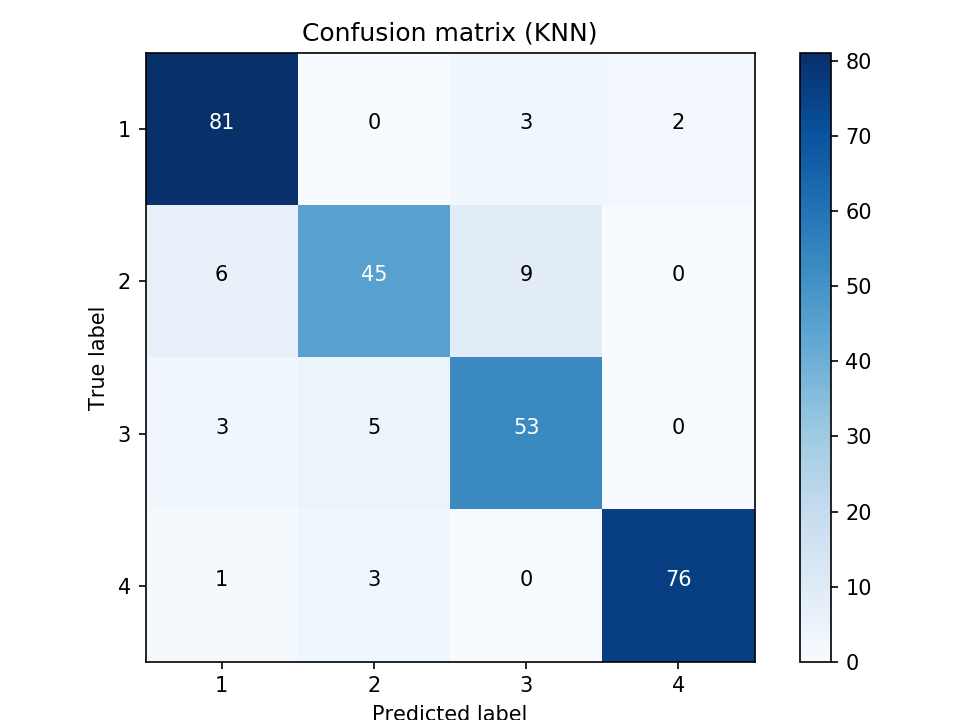

Confusion matrix, without normalization
[[81  0  3  2]
 [ 6 45  9  0]
 [ 3  5 53  0]
 [ 1  3  0 76]]
KNN Average f1 score: 0.8760 (+/- 0.0260)


In [72]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)#, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix

cnf_matrix = confusion_matrix(list(y_test), y_pred)
np.set_printoptions(precision=10)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix (KNN)')


plt.show()
#pdcnf_matrix.print_stats()

### Accuracy with f_micro and f_macro:
scores = cross_val_score(classifier,X_train, y_train, cv=5, scoring='f1_micro')
print("KNN Average f1 score: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()*2))
##print(classification_report(y_test, y_pred, target_names=target_names))


## Now we use Random Forrest classifier (training)

## Testing with Random Forrest classifier

In [73]:
classifier2 = RandomForestClassifier(max_depth=5, random_state=0)

y_pred_RF = classifier2.fit(X_train, y_train).predict(X_test)

### Confusion Matrix and f1 scores

<IPython.core.display.Javascript object>


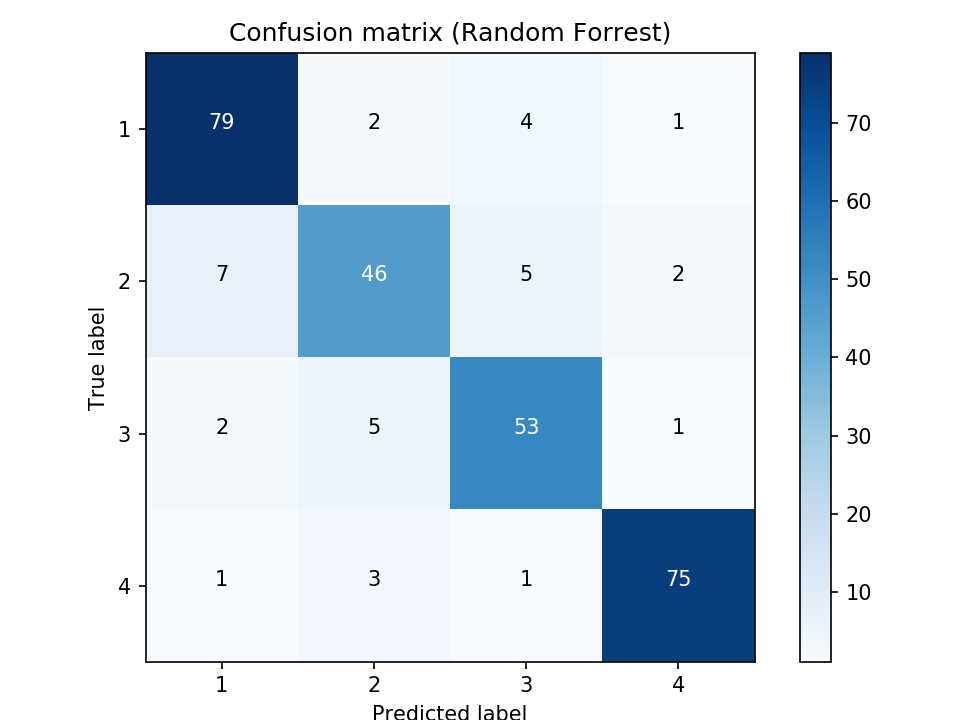

Confusion matrix, without normalization
[[79  2  4  1]
 [ 7 46  5  2]
 [ 2  5 53  1]
 [ 1  3  1 75]]
RF Average f1 score: 0.8664 (+/- 0.0165)


In [74]:
# Compute confusion matrix

cnf_matrix2 = confusion_matrix(list(y_test), y_pred_RF)
np.set_printoptions(precision=10)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=class_names,
                      title='Confusion matrix (Random Forrest)')


plt.show()
#pdcnf_matrix.print_stats()

### Accuracy with f_micro and f_macro:

scores = cross_val_score(classifier2, X_train, y_train, cv=5, scoring='f1_micro')
print("RF Average f1 score: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()*2))



# Feedforward Neural Network Classification
(We can try different NN architectures: change number of inner layers, dimension of each layer, etc.)


![alt text](ff_NN.png "Feed Forward Neural Network") 

In [88]:
clfnn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(50, 70), random_state=1)   
y_pred_NN= clfnn.fit(X_train, y_train).predict(X_test)

<IPython.core.display.Javascript object>


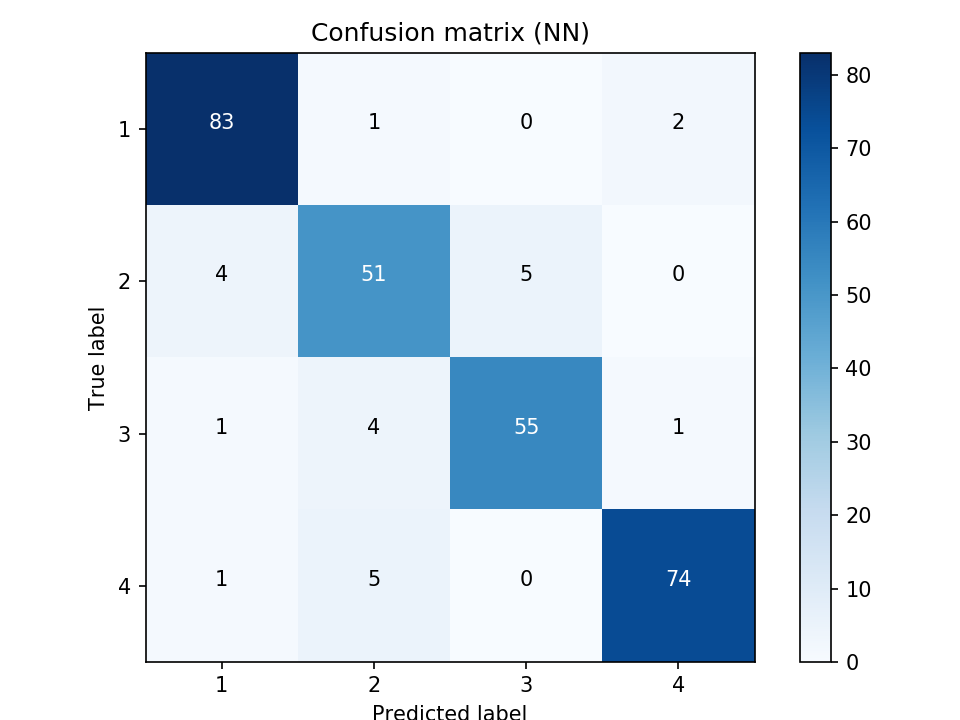

Confusion matrix, without normalization
[[83  1  0  2]
 [ 4 51  5  0]
 [ 1  4 55  1]
 [ 1  5  0 74]]
ff NN Average f1 score: 0.9292 (+/- 0.0244)


In [89]:
# Compute confusion matrix

cnf_matrixNN= confusion_matrix(list(y_test), y_pred_NN)
np.set_printoptions(precision=10)

# Plot non-normalized confusion matrix

plt.figure()
plot_confusion_matrix(cnf_matrixNN, classes=class_names,
                      title='Confusion matrix (NN)')


plt.show()
#pdcnf_matrix.print_stats()

### Accuracy with f_micro and f_macro:
scores = cross_val_score(clfnn, X_train, y_train, cv=5, scoring='f1_micro')
print("ff NN Average f1 score: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()*2))